In [1]:
import pandas as pd
import re

# 1. 데이터 전처리
---
- txt 파일 읽어오기
- 필요 없는 데이터 제거 (첫 두 줄, 줄바꿈만 있는 line, 날짜 구분 line)
- 한 채팅 내에 줄바꿈이 있어 나뉜 경우 처리
- 데이터프레임 형태로 변환

In [2]:
# txt 파일 읽어오기
# 첫 두 줄(필요없는 정보: 파일명, 저장한 날짜) 제거
# \n(줄바꿈만 있는 라인) 제거

def read_msg(file):
    with open(file, encoding='utf-8') as f:
        chatMsg_list = f.readlines()
        del chatMsg_list[0:2]
        chatMsg_list = list(filter(lambda x:x!='\n', chatMsg_list))
    return chatMsg_list

# msg_list = read_msg('파일 경로 변수')
msg_list = read_msg('./3.txt')
#msg_list

In [3]:
# 초대했습니다 있는 줄 삭제
# 갠톡에는 이거 없음
invite_msg = '초대했습니다.'
if invite_msg in msg_list[1]:
    del msg_list[1]
else:
    pass

#msg_list

In [4]:
# 날짜 구분 라인 처리
# 아이폰의 경우 0000. 00. 00. $요일
# 갤럭시의 경우 0000년 00월 00일 오전(or 오후) 00:00

division_line = []
for msg in msg_list:
    dateline = re.match(r"(\d{4}. \d{1,2}. \d{1,2}).\s((\w요일)|((오후|오전)\s(\d{1,2}:\d{2}))\n)", msg)
    division_line.append(dateline)
    
d_index = list(filter(lambda x: division_line[x]!=None, range(len(division_line))))
d_index.reverse()

for i in d_index:
    del msg_list[i]

# 날짜 구분 없애고 채팅 내역만 남은 list
#msg_list

In [5]:
# 1개의 채팅 내에 줄바꿈이 있는 경우 처리

line_break=[]

for msg in msg_list:
    line = re.match(r"(\d{4}. \d{1,2}. \d{1,2}).\s(오후|오전)\s(\d{1,2}:\d{2})", msg)
    line_break.append(line)

b_index = list(filter(lambda x: line_break[x]==None, range(len(line_break))))
b_index.reverse()

for i in b_index:
    msg_list[i-1] = msg_list[i-1]+msg_list[i]
    del msg_list[i]

# 줄바꿈 있는 채팅 처리한 list
#msg_list

In [6]:
# 날짜, 이름, 채팅 내용 각각 리스트로 만들기

date_list = []
name = []
content = []

for msg in msg_list:
    contentFull = msg[:-1].split(',',1)

    try:
        name_and_chat = contentFull[1].split(':',1)
        date_list.append(contentFull[0])
        name.append(name_and_chat[0][1:-1])
        content.append(name_and_chat[1][1:])
        
    except:
        continue
        
print(len)

<built-in function len>


In [7]:
# list to DataFrame

df = pd.DataFrame(data = date_list, columns = ['date'])
df['name'] = name
df['message'] = content

df
# df.to_csv('kakaochat_to_csv.csv', index=False)

,date,name,message
0,2021. 3. 20. 오후 4:52,김세한,!!
1,2021. 3. 20. 오후 4:52,학수,화이팅!!
2,2021. 3. 20. 오후 4:52,이지수,화이팅~~~
3,2021. 3. 20. 오후 4:52,강석훈,화이팅!!
4,2021. 3. 20. 오후 4:52,김세한,화이팅입니다!
...,...,...,...
559,2021. 3. 25. 오후 9:16,학수,다같이 하는건가요😀😀😀😀
560,2021. 3. 25. 오후 9:17,강석훈,"오늘 하게 되면 저하고 지수님, 세한님만 해도 될 것같긴 합니다...!"
561,2021. 3. 25. 오후 9:17,이지수,네네
562,2021. 3. 25. 오후 9:17,학수,알겠습니다🤸


# 2. 데이터 분석

### 1) 얼마나 참여하였는가? (채팅 빈도)

In [8]:
# 이름별로 열 개수 세기

freq = df.groupby(['name']).count()
freq = freq.drop(['date'], axis=1)
freq.rename(columns = {'message' : 'count'}, inplace = True)

freq

,count
name,
강석훈,137
김세한,26
박근영,52
이지수,115
임찬,63
학수,171


### 2) 얼마나 자주 사과했는가? ('죄송' 단어 출연 빈도)

In [9]:
# 이름별로 '죄송'이라는 단어를 포함한 열 개수 세기

sorry = df[df['message'].str.contains('죄송')]

freq_sorry = sorry.groupby(['name']).count()
freq_sorry = freq_sorry.drop(['date'], axis=1)
freq_sorry.rename(columns = {'message' : 'count'}, inplace = True)

freq_sorry

,count
name,
학수,3


### 3) 파일 공유를 얼마나 자주 했는가? ('파일: ' 출연 빈도)

In [10]:
# 파일 공유하면 내보내기한 txt 파일에는 '파일: 파일명.확장자'라고 표시됨
# 이름별로 '파일: ' 포함한 열 개수 세기
file_share = df[df['message'].str.contains('파일: ')]

freq_file = file_share.groupby(['name']).count()
freq_file = freq_file.drop(['date'], axis=1)
freq_file.rename(columns = {'message' : 'count'}, inplace = True)

freq_file

,count
name,
김세한,1


## [Issue]
---
groupby().count() 사용하면 조건에 해당하지 않는 사람은 df에서 누락

-> 사과 횟수, 파일 공유 횟수 열 추가

In [11]:
df['Apology_count'] = df['message'].apply(lambda x: 1 if '죄송' in x else 0)
df['Fileshare_count'] = df['message'].apply(lambda x: 1 if '파일: ' in x else 0)

count_df = df[['name', 'Apology_count', 'Fileshare_count']]
count_df.set_index('name')

,Apology_count,Fileshare_count
name,,
김세한,0,0
학수,0,0
이지수,0,0
강석훈,0,0
김세한,0,0
...,...,...
학수,0,0
강석훈,0,0
이지수,0,0


In [12]:
freq_count = count_df.groupby(['name']).sum()
freq_count

,Apology_count,Fileshare_count
name,,
강석훈,0,0
김세한,0,1
박근영,0,0
이지수,0,0
임찬,0,0
학수,3,0


# 3. 데이터 시각화
---
일단 그냥 대충 막대그래프만 진짜 대충 그려봄

In [13]:
import matplotlib.pyplot as plt

In [14]:
# 한글 폰트 깨짐 방지
# 개인 컴퓨터에 깔린 폰트 따라 코드 달라짐

plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['font.family'] = 'Malgun Gothic'

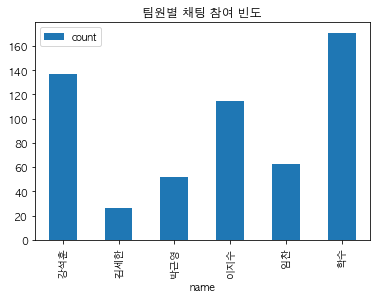

In [15]:
freq_barplot = freq.plot(kind='bar',  title="팀원별 채팅 참여 빈도")
plt.show()

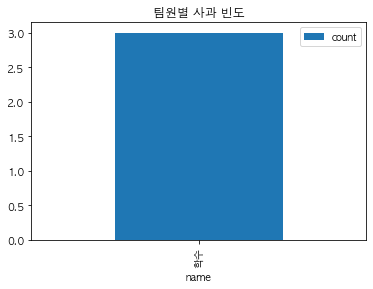

In [16]:
sorry_barplot = freq_sorry.plot(kind='bar',  title="팀원별 사과 빈도")
plt.show()

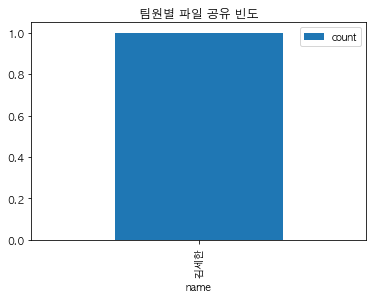

In [17]:
fileShare_barplot = freq_file.plot(kind='bar',  title="팀원별 파일 공유 빈도")
plt.show()

## [Issue]
---
데이터 누락 해결 후 그래프 그리면 아래와 같음.

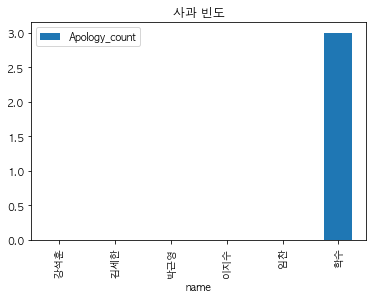

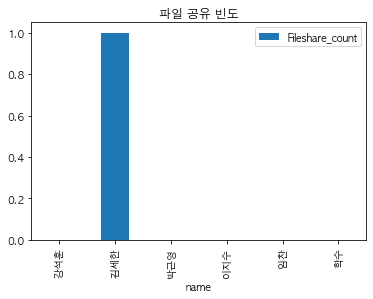

In [18]:
count_df = df[['name', 'Apology_count', 'Fileshare_count']]
sorry_df = freq_count[['Apology_count']]
fileShare_df = freq_count[['Fileshare_count']]

sorryGraph = sorry_df.plot(kind='bar',  title="사과 빈도")
plt.show()

fileShareGraph = fileShare_df.plot(kind='bar',  title="파일 공유 빈도")
plt.show()